In [206]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt

In [207]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal, rankdata, norm
from matplotlib import pyplot as plt
from datetime import datetime

# Types
from collections.abc import Sequence
from typing import Literal
import numpy.typing as npt

In [208]:
# Set random seeds

torch.manual_seed(1)
torch.cuda.manual_seed(1)

## Data Generation

In [209]:
INPUT_SIZE = 128

In [210]:
mu_0 = np.repeat(0, INPUT_SIZE)
sigma_0 = np.zeros((INPUT_SIZE,INPUT_SIZE))
sigma_0[:,:] = 0.8
np.fill_diagonal(sigma_0, 1)
sigma_0

array([[1. , 0.8, 0.8, ..., 0.8, 0.8, 0.8],
       [0.8, 1. , 0.8, ..., 0.8, 0.8, 0.8],
       [0.8, 0.8, 1. , ..., 0.8, 0.8, 0.8],
       ...,
       [0.8, 0.8, 0.8, ..., 1. , 0.8, 0.8],
       [0.8, 0.8, 0.8, ..., 0.8, 1. , 0.8],
       [0.8, 0.8, 0.8, ..., 0.8, 0.8, 1. ]])

In [211]:
mu_1 = np.concatenate([np.repeat(100, INPUT_SIZE/2), np.repeat(200,INPUT_SIZE/2)])
sigma_1 = np.zeros((INPUT_SIZE,INPUT_SIZE))
sigma_1[:4,:4] = 0.7
sigma_1[4:,4:] = 0.2
np.fill_diagonal(sigma_1, 1)
sigma_1

array([[1. , 0.7, 0.7, ..., 0. , 0. , 0. ],
       [0.7, 1. , 0.7, ..., 0. , 0. , 0. ],
       [0.7, 0.7, 1. , ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 1. , 0.2, 0.2],
       [0. , 0. , 0. , ..., 0.2, 1. , 0.2],
       [0. , 0. , 0. , ..., 0.2, 0.2, 1. ]])

In [212]:
def generate_data(sample_size: tuple[int, int], seed: int, shuffle=True) -> tuple[npt.NDArray, npt.NDArray]:
    '''
    Parameters:
        sample_size: a tuple of (h0_size, h1_size)
        shuffle: should we shuffle the training data (otherwise the order will be: all h0 samples, then all h1 samples)
    Returns:
        tuple of (x_values, labels)
    '''
    np.random.seed(seed)
    
    # Generate the data
    x0 = multivariate_normal.rvs(mean=mu_0, cov=sigma_0, size=sample_size[0])
    x1 = multivariate_normal.rvs(mean=mu_1, cov=sigma_1, size=sample_size[1])
    x = np.concatenate([x0, x1], axis=0)
    y = np.concatenate([np.repeat(0,sample_size[0]), np.repeat(1,sample_size[1])])
    
    # shuffle if required 
    if shuffle:
        rng = np.random.default_rng(123)
        xy = np.concatenate([x, y.reshape(-1,1)],axis=1) # we want to shuffle x and y in the same order...
        rng.shuffle(xy)
        #split back to x_train and y_train
        x = xy[:,:10]
        y = xy[:,10:]
        y = y.reshape([-1]).astype(np.int64)
        
    print(F"Generated data shape for size {sample_size}:\r\n\tx: {x.shape}\r\n\t y: {y.shape}")
    return (x, y)

In [213]:
train_100 = generate_data((50,50), 1, shuffle=False)
train_10k = generate_data((5000,5000), 1, shuffle=False)

Generated data shape for size (50, 50):
	x: (100, 128)
	 y: (100,)
Generated data shape for size (5000, 5000):
	x: (10000, 128)
	 y: (10000,)


In [214]:
import torch.utils.data as Data
from torch.utils.data import Dataset as Dataset

class SimpleDataSet(Dataset):
    def __init__(self, x, y):
        super(SimpleDataSet, self).__init__()
        assert x.shape[0] == y.shape[0] # assuming shape[0] = dataset size
        self.x = x
        self.y = y

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
def create_loader_for_data(data, batch_size=32, shuffle=True):
    dataset = SimpleDataSet(data[0], data[1])
    return Data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle)

def create_single_batch_loader_for_data(data, shuffle=True):
    return create_loader_for_data(data, batch_size=len(data[0]), shuffle=True)

In [265]:
train_10K_h0_loader = create_loader_for_data((train_10k[0][:4000],train_10k[1][:4000]))
test_10K_h0_loader = create_loader_for_data((train_10k[0][4000:5000],train_10k[1][4000:5000]))

In [252]:
# Defining the device

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [266]:
# Defining the model

d = 5

class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(INPUT_SIZE, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, d * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(d, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, INPUT_SIZE),
            # nn.ReLU(),
        )

    def reparameterise(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.new_empty(std.size()).normal_()
            return eps.mul_(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        mu_logvar = self.encoder(x.view(-1, INPUT_SIZE)).view(-1, 2, d)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        z = self.reparameterise(mu, logvar)
        return self.decoder(z), mu, logvar

model = VAE().to(device)

In [267]:
# Setting the optimiser

learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

In [268]:
# Reconstruction + β * KL divergence losses summed over all elements and batch

def loss_function(x_hat, x, mu, logvar, β=1):
    # base_loss = nn.functional.binary_cross_entropy(
    #     x_hat, x.view(-1, INPUT_SIZE), reduction='sum'
    # )
    base_loss = nn.functional.mse_loss(x_hat, x)
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))

    # return base_loss + β * KLD
    return base_loss + 0.2 * KLD

In [269]:
# Training and testing the VAE
def train_and_test(model, train_loader, test_loader):
    epochs = 50
    codes = dict(μ=list(), logσ2=list(), y=list())
    for epoch in range(0, epochs + 1):
        # Training
        if epoch > 0:  # test untrained net first
            model.train()
            train_loss = 0
            for x, _ in train_loader:
                x = x.to(device).type(torch.FloatTensor)
                # ===================forward=====================
                x_hat, mu, logvar = model(x)
                loss = loss_function(x_hat, x, mu, logvar)
                train_loss += loss.item()
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            # ===================log========================
            print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')

        # Testing
        means, logvars, labels = list(), list(), list()
        with torch.no_grad():
            model.eval()
            test_loss = 0
            for x, y in test_loader:
                x = x.to(device).type(torch.FloatTensor)
                # ===================forward=====================
                x_hat, mu, logvar = model(x)
                test_loss += loss_function(x_hat, x, mu, logvar).item()
                # =====================log=======================
                means.append(mu.detach())
                logvars.append(logvar.detach())
                labels.append(y.detach())
        # ===================log========================
        codes['μ'].append(torch.cat(means))
        codes['logσ2'].append(torch.cat(logvars))
        codes['y'].append(torch.cat(labels))
        test_loss /= len(test_loader.dataset)
        print(f'====> Test set loss: {test_loss:.4f}')
        # display_images(x, x_hat, 1, f'Epoch {epoch}')

In [270]:
train_and_test(model,train_10K_h0_loader, test_10K_h0_loader)

====> Test set loss: 0.0735
====> Epoch: 1 Average loss: 0.0387
====> Test set loss: 0.0332
====> Epoch: 2 Average loss: 0.0325
====> Test set loss: 0.0313
====> Epoch: 3 Average loss: 0.0313
====> Test set loss: 0.0309
====> Epoch: 4 Average loss: 0.0309
====> Test set loss: 0.0304
====> Epoch: 5 Average loss: 0.0307
====> Test set loss: 0.0300
====> Epoch: 6 Average loss: 0.0306
====> Test set loss: 0.0299
====> Epoch: 7 Average loss: 0.0305
====> Test set loss: 0.0298
====> Epoch: 8 Average loss: 0.0305
====> Test set loss: 0.0301
====> Epoch: 9 Average loss: 0.0304
====> Test set loss: 0.0300
====> Epoch: 10 Average loss: 0.0304
====> Test set loss: 0.0305
====> Epoch: 11 Average loss: 0.0304
====> Test set loss: 0.0306
====> Epoch: 12 Average loss: 0.0304
====> Test set loss: 0.0302
====> Epoch: 13 Average loss: 0.0303
====> Test set loss: 0.0296
====> Epoch: 14 Average loss: 0.0303
====> Test set loss: 0.0299
====> Epoch: 15 Average loss: 0.0303
====> Test set loss: 0.0300
====> 

In [164]:
# Let's see the ranking of our learned data
x_mapped = None
with torch.no_grad():
    model.eval()
    x_mapped = model(torch.from_numpy(train_10k[0][:5000]).type(torch.FloatTensor))

In [165]:
# regularization
# 1. Separate KLD for EACH component
# 2. Use a loss function over Z that includes the NLL (maybe transfer Z via autoencoder)

In [271]:
with torch.no_grad():
    model.eval()
    sample_10_restor = model(torch.from_numpy(train_10k[0][10]).type(torch.FloatTensor))
print(train_10k[0][10])
print(sample_10_restor)

[-0.05251875 -1.17200514 -0.16774701 -0.39898241 -0.32964164 -0.44203436
 -0.41329284 -0.06710394 -0.86608995 -1.20459811 -0.92955366  0.02782698
 -0.59888295 -0.10202583  0.11457683 -0.77928845 -0.54822295 -0.33802032
 -0.66671229  0.12107948 -0.08650208  0.01299249 -0.84009762  0.00581078
  0.08967618  0.20494165 -0.4684479  -0.70942385 -1.01371614 -1.20941913
 -1.09418604 -0.11791377 -0.16807186 -0.22557446 -0.0218348  -0.45134016
 -0.72678003 -0.34265219 -0.26821957 -0.25615952  0.61588299  0.19352362
 -0.42928739 -0.94846891 -0.40793227  0.29635173 -0.777276   -0.83671961
 -0.31483594 -0.97227212  0.04696967 -0.45004296 -0.34496572  0.27281053
 -0.49224596 -0.4707652  -0.40136768 -0.59449352 -0.19841346 -0.51333225
  0.20540769 -0.50553371 -0.79780909 -0.22482924 -0.37297701 -0.64418742
 -0.36247997 -0.0831103  -1.11513478 -0.05443596 -0.16850514  0.1392927
  0.1102439  -0.1311456   0.00719863 -0.21253549  0.6846426  -0.38235374
  0.15396151 -0.41734726  0.02335356 -0.18195047 -0.

In [192]:
train_10k[0][10]

array([ 0.44807067, -0.50800937,  1.54610575, -1.27847558,  1.10252366,
        0.42191784,  0.99647199,  0.30062482,  1.0035537 , -1.49046048,
       -2.15730186, -1.08385894, -0.07697875, -0.74363848, -1.57293199,
       -0.83127137,  1.89002334, -0.47828566, -0.22828902,  0.05531881,
       -0.42474625, -0.89831962, -1.60910691, -0.95890231,  0.12212274,
        0.36897725,  0.6219621 , -1.75613784, -0.03971947, -1.31717674,
       -0.31197964,  0.4760673 , -0.22401164, -0.95821472,  0.67158733,
        0.3174948 , -0.33049132, -1.72574179, -1.1187633 ,  0.20469841,
       -0.45367984,  0.2283301 , -1.11739937,  0.45201197,  0.37450981,
       -0.50790672, -0.10090971,  1.37883407,  0.46209631,  1.65916572,
        0.73907902, -1.04756701, -1.43360872, -0.45957089, -0.27423945,
        0.52775607, -0.60224   ,  0.31916113, -0.35727205, -0.39274829,
       -0.33522079,  0.59796665,  0.70114074,  0.67087372, -0.08157452,
       -1.75577715, -0.36145005, -0.81705131, -0.30439441,  0.60

In [193]:
sample_10_restor

(tensor([[3.9875e-06, 1.6725e-05, 2.5002e-04, 1.2720e-04, 1.7129e-17, 5.3061e-14,
          2.0358e-15, 1.0545e-25, 1.1075e-17, 3.6892e-19, 4.3549e-26, 6.9308e-16,
          1.2097e-19, 8.7880e-18, 1.0822e-15, 2.1510e-20, 3.7693e-17, 1.8685e-26,
          3.7229e-18, 1.4566e-22, 3.1606e-24, 1.2916e-23, 2.7463e-35, 9.8524e-20,
          2.0571e-21, 8.2912e-19, 2.0555e-27, 5.5582e-19, 7.4632e-32, 2.0958e-21,
          1.6506e-24, 2.0807e-15, 2.4660e-22, 1.7908e-23, 1.3022e-24, 9.2848e-23,
          8.9351e-27, 2.0193e-22, 1.8431e-31, 2.9491e-18, 1.8292e-26, 9.6715e-27,
          6.2424e-21, 3.0177e-19, 5.6094e-23, 1.9519e-16, 5.1540e-28, 6.6587e-22,
          8.4423e-19, 6.5062e-21, 4.1638e-14, 7.7595e-14, 2.0143e-18, 9.4627e-21,
          2.0761e-17, 7.1377e-26, 6.6689e-15, 6.7714e-24, 1.2828e-18, 4.7042e-22,
          1.8941e-26, 1.3967e-20, 4.7065e-24, 2.9265e-13, 5.2606e-25, 1.2774e-25,
          2.0646e-15, 2.3117e-30, 3.6409e-16, 1.2120e-17, 6.1420e-16, 5.8147e-20,
          4.5363

In [ ]:
with torch.no_grad():
    model.eval()
    x_mapped = model(torch.from_numpy(train_10k[0][:5000]).type(torch.FloatTensor))

In [166]:
x_mapped_mu = x_mapped[1]

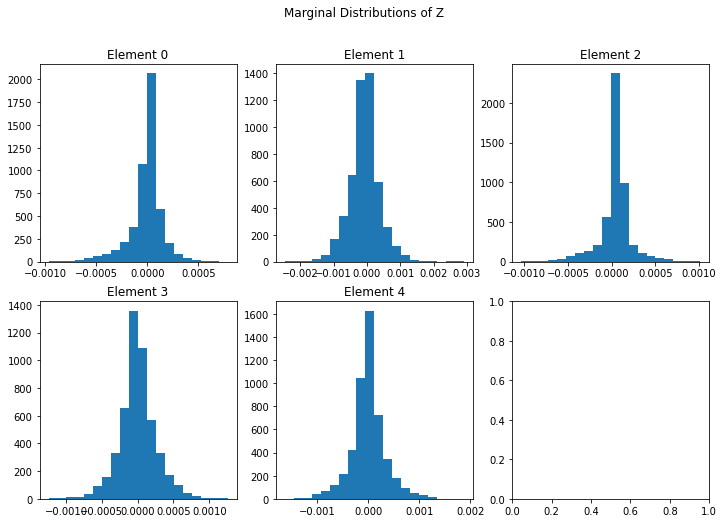

In [176]:
std_fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,8))
std_fig.suptitle('Marginal Distributions of Z')
for i in range(5):
    ax = axes[int(i/3),i%3]
    ax.hist(x_mapped_mu[:,i].numpy(), 20)
    ax.set_title(F"Element {i}")
plt.show()

In [177]:
df = pd.DataFrame(x_mapped_mu.numpy())
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,0,1,2,3,4
0,1.000000,0.007840,-0.160790,-0.757863,-0.670809
1,0.007840,1.000000,0.443027,-0.219073,0.226218
2,-0.160790,0.443027,1.000000,0.503953,0.578572
3,-0.757863,-0.219073,0.503953,1.000000,0.752952
4,-0.670809,0.226218,0.578572,0.752952,1.000000


In [45]:
# Generating a few samples

N = 16
z = torch.randn((N, d)).to(device)
# sample = model.decoder(torch.from_numpy(x0).type(torch.FloatTensor))
sample = model.decoder(z)
sample.shape
# display_images(None, sample, N // 4, count=True)

torch.Size([16, 128])

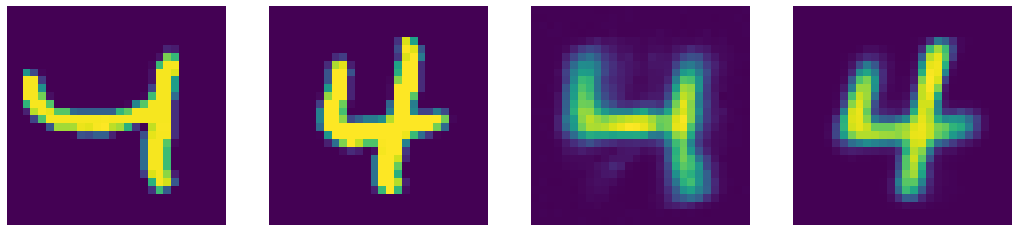

In [62]:
# Choose starting and ending point for the interpolation -> shows original and reconstructed

A, B = 1, 14
sample = model.decoder(torch.stack((mu[A].data, mu[B].data), 0))
display_images(None, torch.stack(((
    x[A].data.view(-1),
    x[B].data.view(-1),
    sample.data[0],
    sample.data[1]
)), 0))

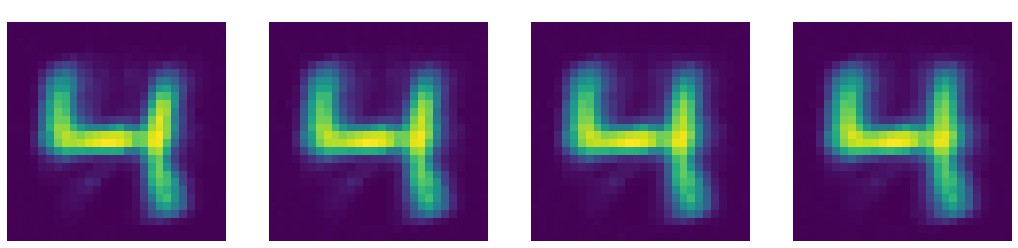

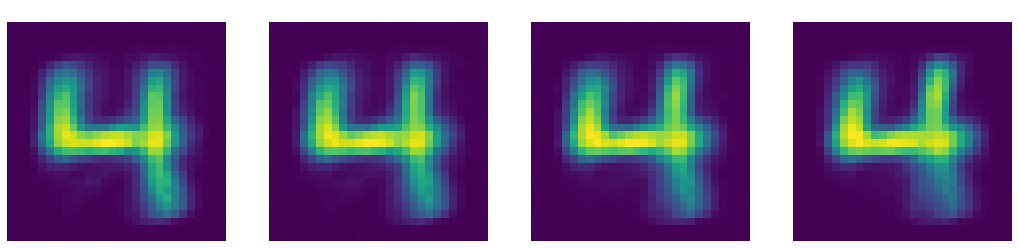

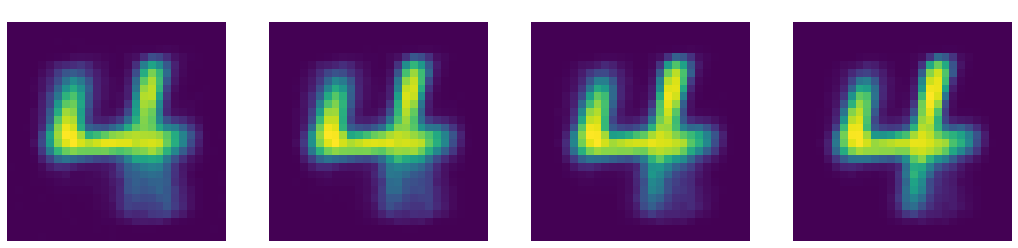

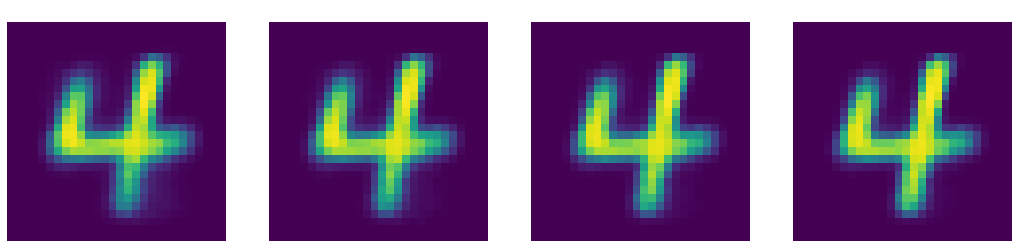

In [63]:
# Perform an interpolation between input A and B, in N steps

N = 16
code = torch.Tensor(N, 20).to(device)
sample = torch.Tensor(N, 28, 28).to(device)
for i in range(N):
    code[i] = i / (N - 1) * mu[B].data + (1 - i / (N - 1) ) * mu[A].data
    # sample[i] = i / (N - 1) * x[B].data + (1 - i / (N - 1) ) * x[A].data
sample = model.decoder(code)
display_images(None, sample, N // 4, count=True)

In [53]:
import numpy as np
from sklearn.manifold import TSNE
from res.plot_lib import set_default

ModuleNotFoundError: No module named 'res'

In [ ]:
set_default(figsize=(15, 4))

In [ ]:
X, Y, E = list(), list(), list()  # input, classes, embeddings
N = 1000  # samples per epoch
epochs = (0, 5, 10)
for epoch in epochs:
    X.append(codes['μ'][epoch][:N])
    E.append(TSNE(n_components=2).fit_transform(X[-1].detach().cpu()))
    Y.append(codes['y'][epoch][:N])

In [ ]:
f, a = plt.subplots(ncols=3)
for i, e in enumerate(epochs):
    s = a[i].scatter(E[i][:,0], E[i][:,1], c=Y[i], cmap='tab10')
    a[i].grid(False)
    a[i].set_title(f'Epoch {e}')
    a[i].axis('equal')
f.colorbar(s, ax=a[:], ticks=np.arange(10), boundaries=np.arange(11) - .5)